In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
#import cartopy.feature as cfeat
#import cartopy.io.img_tiles as cimgt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
#import AISMapPlot as aismap
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [2]:
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']

# import test set
test = pd.read_csv('flex_rot.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [3]:
ais_nan = test

# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [4]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan
# Set invalid breadths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)
ais_test= ais_dropped


# Get times finish line is crossed, by trips that do cross it
finish_line_ts = ais_test[ais_test['Longitude'] > 3.94].groupby('TripID')['time'].min()

# Only keep trips that do cross the finish line
ais_ham_zoned = ais_test[ais_test['TripID'].isin(finish_line_ts.index)]

#Set EndTime to the time the ship first appears behind the finish line
for tripid in finish_line_ts.index :
    ais_ham_zoned.loc[ais_ham_zoned['TripID'] == tripid, 'EndTime'] = finish_line_ts.loc[tripid]

# Throw out all records after the finish line was crossed
ais_ham_zoned = ais_ham_zoned[ais_ham_zoned['time'] <= ais_ham_zoned['EndTime']]

# Add time for the entire trip to the data
ais_ham_zoned['TravelTime'] = ais_ham_zoned['EndTime'] - ais_ham_zoned['StartTime']
ais_ham_zoned['TravelTimeMins'] = ais_ham_zoned['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_ham_zoned['remainingTT'] = ais_ham_zoned['EndTime'] - ais_ham_zoned['time']
ais_ham_zoned['remainingMins'] = ais_ham_zoned['remainingTT'].transform(lambda x : x.total_seconds() / 60)


ais_test = ais_ham_zoned
ais_test = ais_test[['Latitude', 'Longitude', 'COG', 'SOG', 'remainingMins']]

C:\Users\eijoa\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
ais_test = ais_test.dropna()
# ais_test

,Latitude,Longitude,COG,SOG,remainingMins
1,51.95,1.31,264.0,1.2,410.0
2,51.95,1.31,285.0,2.3,409.0
3,51.95,1.30,280.0,4.6,408.0
4,51.95,1.30,251.0,3.7,407.0
5,51.95,1.30,210.0,3.8,406.0
6,51.95,1.30,170.0,4.8,405.0
7,51.94,1.30,162.0,6.3,404.0
8,51.94,1.30,162.0,8.1,403.0
9,51.94,1.30,169.0,9.8,402.0
10,51.94,1.30,175.0,11.1,401.0


In [6]:
ais_learners = []
sectors = [0, 1, 2]
sector_borders = [2.2, 3.2, 3.94]
positions = pd.DataFrame([[np.nan, 2.2], [np.nan, 3.2], [np.nan, 3.94]],
                         columns = ['Latitude', 'Longitude'])
for s in sectors:
    ais_learners.append(pd.read_pickle('FEL-ROT_learners_01min_s%d.pkl' % (s)))

In [7]:
# create complete dataset again, without being seperated into sectors
# needed to train single agent machine learner

complete = ais_learners[0]
complete = complete.append(ais_learners[1])
complete = complete.append(ais_learners[2])

In [8]:
# input and output for machine learners
X = complete[['Latitude', 'Longitude', 'COG', 'SOG']]
y = complete['remainingMins']

In [9]:
# create 10 Splits, seperate by complete Trips
cv_splits = list(GroupKFold(n_splits = 10).split(X, y, groups = complete['TripID']))

In [10]:
# cv_splits

[(array([     0,      1,      2, ..., 374944, 374945, 374946]),
  array([    78,     79,     80, ..., 374456, 374457, 374458])),
 (array([     0,      1,      2, ..., 374944, 374945, 374946]),
  array([  1860,   1861,   1862, ..., 374274, 374275, 374276])),
 (array([     0,      1,      2, ..., 374944, 374945, 374946]),
  array([   250,    251,    252, ..., 374683, 374684, 374685])),
 (array([     0,      1,      2, ..., 374944, 374945, 374946]),
  array([   564,    565,    566, ..., 374819, 374820, 374821])),
 (array([     0,      1,      2, ..., 374944, 374945, 374946]),
  array([   862,    863,    864, ..., 374917, 374918, 374919])),
 (array([     0,      1,      2, ..., 374944, 374945, 374946]),
  array([  3251,   3252,   3253, ..., 374794, 374795, 374796])),
 (array([    78,     79,     80, ..., 374944, 374945, 374946]),
  array([     0,      1,      2, ..., 374581, 374582, 374583])),
 (array([     0,      1,      2, ..., 374944, 374945, 374946]),
  array([   391,    392,    393, 

In [11]:
# Create a train-test split
train_indices, test_indicies = cv_splits[0]
X_train, X_test = X.iloc[train_indices], X.iloc[test_indicies]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indicies]

In [12]:
# X_train

,Latitude,Longitude,COG,SOG
336698,52.03,1.69,88.0,8.1
336699,52.03,1.70,88.1,8.2
336700,52.03,1.70,90.1,8.3
336701,52.03,1.70,88.7,8.5
336533,52.03,1.71,87.9,8.2
336745,52.03,1.71,93.5,7.5
336539,52.03,1.71,88.1,8.0
336704,52.03,1.72,89.6,7.8
336705,52.03,1.72,89.7,8.2
336746,52.03,1.73,87.6,8.5


In [13]:
# test various settings for k nearest neighbours

# knn = KNeighborsRegressor()

# knn_params = dict(n_neighbors = range(5, 40), weights = [ 'distance'])
# knn_rand = RandomizedSearchCV(knn, knn_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 5)
# knn_rand.fit(X, y)

# pd.DataFrame(knn_rand.cv_results_).transpose()

In [14]:
# pd.DataFrame(knn_rand.cv_results_).transpose()

In [15]:
# select best performing parameters
knn_best = KNeighborsRegressor(n_neighbors = 41, weights = 'distance')
knn_best.fit(X_train, y_train)

knn_predicts = knn_best.predict(ais_test[['Latitude', 'Longitude', 'COG', 'SOG']])

In [16]:
knn_predicts_diffs = knn_predicts - ais_test['remainingMins']

In [17]:
knn_predicts_frame = pd.DataFrame({'correct': ais_test['remainingMins'], 'knn_predicted': knn_predicts, 'diff': knn_predicts_diffs})
knn_predicts_frame['abs_error'] = knn_predicts_frame['diff'].transform(lambda x: abs(x))
knn_predicts_frame = knn_predicts_frame.sort_values('correct')
knn_predicts_frame['abs_error'].describe()

count    244.000000
mean       4.489143
std       12.481865
min        0.000000
25%        0.000000
50%        0.000000
75%        2.537117
max      147.000000
Name: abs_error, dtype: float64

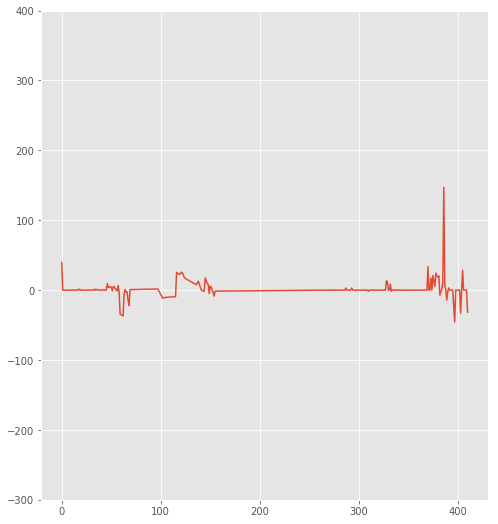

In [18]:
plt.figure(figsize = (8, 9))
axes = plt.gca()
axes.set_ylim([-300,400])
plt.plot(knn_predicts_frame['correct'], knn_predicts_frame['diff'])
plt.savefig('../Images/fel_rot_complete_knn_test.png', dpi = 300, bbox_inches = 'tight')

In [19]:
#test various settings for random forest

# rfo = RandomForestRegressor()
# rfo_params = dict(n_estimators = range(1, 10), max_depth = range(5,15))
# rfo_rand = RandomizedSearchCV(rfo, rfo_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
# rfo_rand.fit(X, y)

# pd.DataFrame(rfo_rand.cv_results_)

In [20]:
# select best performing parameters
rfr_best = RandomForestRegressor(max_depth = 10, n_estimators = 15)
rfr_best.fit(X_train, y_train)

rfr_predicts = rfr_best.predict(ais_test[['Latitude', 'Longitude', 'COG', 'SOG']])

In [21]:
rfr_predicts_diffs = rfr_predicts - ais_test['remainingMins']

In [22]:
rfr_predicts_frame = pd.DataFrame({'correct': ais_test['remainingMins'], 'rfr_predicted': rfr_predicts, 'diff': rfr_predicts_diffs})
rfr_predicts_frame['abs_error'] = rfr_predicts_frame['diff'].transform(lambda x: abs(x))
rfr_predicts_frame = rfr_predicts_frame.sort_values('correct')
rfr_predicts_frame['abs_error'].describe()

count    244.000000
mean      19.683740
std       18.166572
min        0.339632
25%        6.201198
50%       15.843015
75%       26.074037
max       92.402646
Name: abs_error, dtype: float64

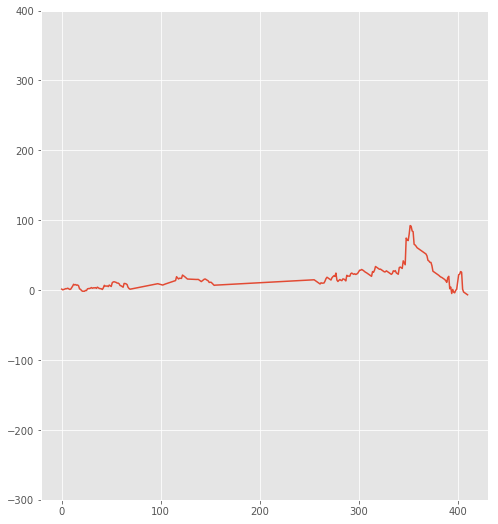

In [23]:
plt.figure(figsize = (8, 9))
axes = plt.gca()
axes.set_ylim([-300,400])
plt.plot(rfr_predicts_frame['correct'], rfr_predicts_frame['diff'])
plt.savefig('../Images/fel_rot_complete_rfr_test.png', dpi = 300, bbox_inches = 'tight')

In [28]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(7),max_iter=1000, random_state = 1)
mlp.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=7, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [29]:
ann_predicts= mlp.predict(ais_test[['Latitude', 'Longitude', 'COG', 'SOG']])
ann_predicts_diffs = ann_predicts - ais_test['remainingMins']
ann_predicts_frame = pd.DataFrame({'correct': ais_test['remainingMins'], 'ann_predicted': ann_predicts, 'diff': ann_predicts_diffs})
ann_predicts_frame['abs_error'] = ann_predicts_frame['diff'].transform(lambda x: abs(x))
ann_predicts_frame = ann_predicts_frame.sort_values('correct')
ann_predicts_frame['abs_error'].describe()

count    244.000000
mean      23.260181
std       20.242641
min        0.061057
25%        7.385692
50%       14.695471
75%       34.235535
max       87.446008
Name: abs_error, dtype: float64

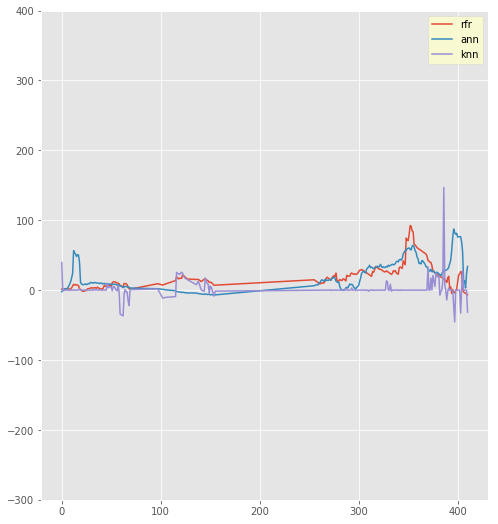

In [30]:
plt.figure(figsize = (8, 9))
axes = plt.gca()
axes.set_ylim([-300,400])
plt.plot(rfr_predicts_frame['correct'], rfr_predicts_frame['diff'], label = 'rfr')
plt.plot(ann_predicts_frame['correct'], ann_predicts_frame['diff'], label = 'ann' )
plt.plot(knn_predicts_frame['correct'], knn_predicts_frame['diff'], label = 'knn')
plt.legend().get_frame().set_facecolor('#FFFFCC')

plt.savefig('../Images/fel_rot_complete_all_test.png', dpi = 300, bbox_inches = 'tight')